# TABLE OF CONTENTS

* [Read Graphs](#read_graphs)
* [Global Variable Initialization](#global_variable_initialization)
* [Drawing Functions](#drawing_functions)
* [Node Importance](#node_importance)
    * [Page Rank](#page_rank)
* [Community Detection](#community_detection)
    * [Algorithms](#community_detection_algorithms)
        * [Lowest Weight Removal](#community_detection_lwr)
        * [Girvan Newman](#community_detection_gn)
        * [Cliques](#community_detection_cliques)
        * [Louvain](#community_detection_louvain)
    * [Execution](#community_detection_execution)
        * [Lowest Weight Removal](#execution_lwr)
        * [Girvan Newman](#execution_gn)
        * [Cliques](#execution_cliques)
        * [Louvain](#execution_louvain)
* [Load Graph Progressions](#load_graph_pregressions)
* [Link Prediction](#link_prediction)
    * [Predictors](#lp_predictors)
        * [Random Predictor](#lp_rp)
        * [Common Neighbors](#lp_cn)
        * [Jaccard](#lp_jc)
        * [Preferential Attachment](#lp_pa)
        * [Adamic/Adar](#lp_aa)
    * [Execution](#link_prediction_execution)
* [Statistics](#statistics)
    * [Functions](#statistics_functions)
    * [Execution](#statistics_execution)
        * [SIR Graph](#sir)
        * [R0 Graph](#r0)
        * [Infections Graph](#infections)
        * [Final Infections Result](#fir)
        * [Vaccination Cascade](#vc)

In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import community.community_louvain as community
import json

# READ GRAPHS <a class="anchor" id="read_graphs"></a>

In [2]:
f = open("images/graphP.json")
edges = f.read().split('\n')
f.close()
f = open("images/graphG.json")
edgesG = f.read().split('\n')
f.close()
f = open("images/mask_graphP.json")
Medges = f.read().split('\n')
f.close()
f = open("images/mask_graphG.json")
MedgesG = f.read().split('\n')
f.close()
f = open("images/vax_graphP.json")
Vedges = f.read().split('\n')
f.close()
f = open("images/vax_graphG.json")
VedgesG = f.read().split('\n')
f.close()
f = open('images/ts.txt')
TS = int(f.read())
f.close()
f = open('images/vax_ts.txt')
VTS = int(f.read())
f.close()
f = open('images/mask_ts.txt')
MTS = int(f.read())
f.close()
# json.loads(edges[len(edges)-1])
# Vedges[45]

# GLOBAL VARIABLE INITIALIZATION <a class="anchor" id="global_variable_initialization"></a>

In [3]:
P = nx.Graph()
G = nx.DiGraph()
MP = nx.Graph()
MG = nx.DiGraph()
VP = nx.Graph()
VG = nx.DiGraph()
for edge in edges:
    if edge == '':
        continue
    e = json.loads(edge)
    P.add_edge(e['u'], e['v'], weight=e['weight'], color=e['color'], contacts=e['contacts'])
    P.nodes[e['u']]['dest'] = e['u_public']
    P.nodes[e['v']]['dest'] = e['v_public']
    
for edge in edgesG:
    if edge == '':
        continue
    e = json.loads(edge)
    G.add_edge(e['u'], e['v'])
    G.nodes[e['u']]['state'] = e['u_state']
    G.nodes[e['v']]['state'] = e['v_state']
for edge in Medges:
    if edge == '':
        continue
    e = json.loads(edge)
    VP.add_edge(e['u'], e['v'], weight=e['weight'], color=e['color'], contacts=e['contacts'])
    VP.nodes[e['u']]['dest'] = e['u_public']
    VP.nodes[e['v']]['dest'] = e['v_public']
    
for edge in MedgesG:
    if edge == '':
        continue
    e = json.loads(edge)
    MG.add_edge(e['u'], e['v'])
    MG.nodes[e['u']]['state'] = e['u_state']
    MG.nodes[e['v']]['state'] = e['v_state']
i= 0 
for edge in Vedges:
    i+=1
    if edge == '':
        continue
    e = json.loads(edge)
    VP.add_edge(e['u'], e['v'], weight=e['weight'], color=e['color'], contacts=e['contacts'])
    VP.nodes[e['u']]['dest'] = e['u_public']
    VP.nodes[e['v']]['dest'] = e['v_public']


for edge in VedgesG:
    if edge == '':
        continue
    e = json.loads(edge)
    VG.add_edge(e['u'], e['v'])
    VG.nodes[e['u']]['state'] = e['u_state']
    VG.nodes[e['v']]['state'] = e['v_state']

#GLOBAL VARIABLES
INITIAL_INFECTION = 8
P_community_weights = P.copy()
P_louvain = P.copy()
P_girvan_newman = P.copy()
for u,v in P_girvan_newman.edges():
    P_girvan_newman[u][v]['weight'] = 10000*(1/(P_girvan_newman[u][v]['weight']*P_girvan_newman[u][v]['weight']))
P_community_clique = P.copy()
weight_communities = None
num_comp = 24
# num_comp = 4


# DRAWING FUNCTIONS <a class="anchor" id="drawing_functions"></a>

In [4]:
def draw_P(graph, file_name = ''):
    color_map = []
    color_options = ['#FF0000','#FF9999','#FF8000','#FFFF00','#80FF00','#009900','#66FFB2','#009999','#00FFFF','#004C99',
              '#66B2FF','#9999FF','#0000CC','#7F00FF','#FF00FF','#CC0066','#C0C0C0','#606060','#336600','#999900',
              '#CCCCFF','#CCFFFF','#FFCCFF','#666600']
    for node in graph:       
        mod = int(node) % 24
        color_map.append(color_options[mod])
    colors = [graph[u][v]['color'] for u,v in graph.edges()]
    plt.figure(figsize=(12,12))
    pos = graphviz_layout(graph, prog="fdp")
    nx.draw(graph,pos, node_color=color_map, edge_color=colors, with_labels = True)
    if file_name != '':
        plt.savefig("images/"+file_name+".png")
    plt.show()
    plt.clf()

def draw_P2(graph, file_name = ''):
    color_map = []
    color_options = ['#5EF72F','#FAFA18','#18A0FA','#E22B2B','#80FF00','#009900','#66FFB2','#009999','#00FFFF','#004C99',
              '#66B2FF','#9999FF','#0000CC','#7F00FF','#FF00FF','#CC0066','#C0C0C0','#606060','#336600','#999900',
              '#CCCCFF','#CCFFFF','#FFCCFF','#666600']
    for node in graph:       
        mod = P.nodes[node]['dest']
        color_map.append(color_options[mod])
    colors = [graph[u][v]['color'] for u,v in graph.edges()]
    plt.figure(figsize=(12,12))
    pos = graphviz_layout(graph, prog="fdp")
    nx.draw(graph,pos, node_color=color_map, edge_color=colors, with_labels = True)
    if file_name != '':
        plt.savefig("images/"+file_name+".png")
    plt.show()
    plt.clf()

    
def to_draw_P(graph):
    max_match_house = 0
    max_match_pub = 0

    for n in graph:
        same_house = 0
        same_pub = 0
        neighbors = graph.neighbors(n)
        for x in neighbors:
            if x%24 == n%24:
                same_house += 1
            if P.nodes[n]['dest'] == P.nodes[x]['dest']:
                same_pub += 1
        if max_match_house < same_house:
            max_match_house = same_house
        if max_match_pub < same_pub:
            max_match_pub = same_pub
    if max_match_house > max_match_pub:
        draw_P(graph)
    else:
        draw_P2(graph)
    
def draw_G(graph, file_name = ''):
    color_map = []
    for node in graph:       
        node = graph.nodes[node]['state']
        if (node == 'State.RECOVERED'):
            color_map.append('green')
        else:
            color_map.append('red')
    pos = graphviz_layout(graph, prog="twopi")
    plt.figure(figsize=(10,10))
    nx.draw(graph,pos, node_color=color_map, with_labels = True)
    if file_name != '':
        plt.savefig("images/"+file_name+".png")
    plt.show()
    plt.clf()

    
def draw_VC(graph, file_name = ''):
    color_map = []
    color_options = ['#FF0000','#FF9999','#FF8000','#FFFF00','#80FF00','#009900','#66FFB2','#009999','#00FFFF','#004C99',
              '#66B2FF','#9999FF','#0000CC','#7F00FF','#FF00FF','#CC0066','#C0C0C0','#606060','#336600','#999900',
              '#CCCCFF','#CCFFFF','#FFCCFF','#666600']
    for node in graph:       
        if graph.nodes[node]['is_active']:
            color_map.append('#209E2E') #green
        else:    
            color_map.append('#B3B3B3') #grey
#     colors = [graph[u][v]['color'] for u,v in graph.edges()]
    plt.figure(figsize=(8,8))
    pos = graphviz_layout(graph, prog="fdp")
#     nx.draw(graph,pos, node_color=color_map, edge_color=colors, with_labels = True)
    nx.draw(graph,pos, node_color=color_map, with_labels = True)
    if file_name != '':
        plt.savefig("images/"+file_name+".png")
    plt.show()
    plt.clf()
    
def draw_P_with_edges(graph, file_name = ''):
#     graph = graph.copy()
    color_map = []
    color_options = ['#FF0000','#FF9999','#FF8000','#FFFF00','#80FF00','#009900','#66FFB2','#009999','#00FFFF','#004C99',
              '#66B2FF','#9999FF','#0000CC','#7F00FF','#FF00FF','#CC0066','#C0C0C0','#606060','#336600','#999900',
              '#CCCCFF','#CCFFFF','#FFCCFF','#666600']
    for node in graph:       
        mod = int(node) % 24
        color_map.append(color_options[mod])
    colors = [graph[u][v]['color'] for u,v in graph.edges()]
    
    for n1, n2 in graph.edges:
        conts = []
        contacts = graph[n1][n2]['contacts']
        graph[n1][n2]['contacts'] = []
        cn = [contacts[0], contacts[0]]
        if len(contacts) == 1:
            graph[n1][n2]['contacts'].append(conts)
            continue
        for i in range(1, len(contacts)):
            if (contacts[i]) != (contacts[i-1]+1):
                cn[1] = contacts[i-1]
                conts.append(cn)
                cn = [contacts[i], contacts[i]]
            if i == (len(contacts) - 1):
                cn[1] = contacts[i]
                conts.append(cn)

        if len(conts) > 2:
            conts = [conts[0],'...',conts[len(conts)-1]]
        graph[n1][n2]['contacts']=(conts)
        
    edge_labels = dict([((n1, n2), graph[n1][n2]['contacts']) for n1, n2 in graph.edges()])
    plt.figure(figsize=(12,12))
    pos = graphviz_layout(graph, prog="fdp")
    nx.draw(graph,pos, node_color=color_map, edge_color=colors, with_labels = True)
    nx.draw_networkx_edge_labels(G, pos,edge_labels=edge_labels)
    if file_name != '':
        plt.savefig("images/"+file_name+".png")
    plt.show()
    plt.clf()


def draw_P_with_edge_weight(graph, file_name = ''):
#     graph = graph.copy()
    color_map = []
    color_options = ['#FF0000','#FF9999','#FF8000','#FFFF00','#80FF00','#009900','#66FFB2','#009999','#00FFFF','#004C99',
              '#66B2FF','#9999FF','#0000CC','#7F00FF','#FF00FF','#CC0066','#C0C0C0','#606060','#336600','#999900',
              '#CCCCFF','#CCFFFF','#FFCCFF','#666600']
    for node in graph:       
        mod = int(node) % 24
        color_map.append(color_options[mod])
    colors = [graph[u][v]['color'] for u,v in graph.edges()]
    
        
    edge_labels = dict([((n1, n2), graph[n1][n2]['weight']) for n1, n2 in graph.edges()])
    plt.figure(figsize=(12,12))
    pos = graphviz_layout(graph, prog="fdp")
    nx.draw(graph,pos, node_color=color_map, edge_color=colors, with_labels = True)
    nx.draw_networkx_edge_labels(G, pos,edge_labels=edge_labels)
    if file_name != '':
        plt.savefig("images/"+file_name+".png")
    plt.show()
    plt.clf() 
    
def households(g):
    graph = g.copy()
    for edge in g.edges():
        n1 = edge[0]
        n2 = edge[1]
        if n1%24 != n2%24 and random.randint(0,100)<95:
            graph.remove_edge(n1,n2)
        else:
            g[n1][n2]['color'] = 'grey'
    return graph

def P_at_t(g,t):
    graph = g.copy()
    for edge in g.edges():
        n1 = edge[0]
        n2 = edge[1]
        if t not in g[n1][n2]['contacts']:
            graph.remove_edge(n1,n2)
        else:
            g[n1][n2]['color'] = 'grey'
    return graph

# NODE IMPORTANCE <a class="anchor" id="node_importance"></a>

## PAGE RANK <a class="anchor" id="page_rank"></a>

In [5]:
prP = sorted(nx.pagerank(P).items(), key=lambda pair: -pair[1])
prP_top = prP[0:20]
prP_bottom = prP[-20:]
top_infected = 0
bottom_infected = 0
for n in prP_top:
    n = n[0]
    if G.has_node(n):
        top_infected +=1
res = round(top_infected/len(prP_top)*100,2)
print('Percentage of Top 20 most important nodes that were infected:')
print(str(res) + '%')

for n in prP_bottom:
    n = n[0]
    if G.has_node(n):
        bottom_infected +=1
res = round(bottom_infected/len(prP_bottom)*100,2)
print('Percentage of Top 20 most important nodes that were infected:')
print(str(res) + '%')

Percentage of Top 20 most important nodes that were infected:
90.0%
Percentage of Top 20 most important nodes that were infected:
65.0%


# COMMUNITY DETECTION <a class="anchor" id="community_detection"></a>

## ALGORITHMS <a class="anchor" id="community_detection_algorithms"></a>

#### LOWEST WEIGHT REMOVAL <a class="anchor" id="community_detection_lwr"></a>

In [6]:
def community_detection_weight():  
    i=0
    edges=sorted(P_community_weights.edges(data=True), key=lambda t: t[2].get('weight', 1))
    while nx.number_connected_components(P_community_weights) < num_comp:
        e = edges[i]
        P_community_weights.remove_edge(e[0],e[1])
        i+=1
    components = sorted(nx.connected_components(P_community_weights), key=len, reverse=True)
    weight_communities = components


#### GIRVAN NEWMAN <a class="anchor" id="community_detection_gn"></a>

In [7]:
def girvan_newman():   
    ebP = nx.edge_betweenness_centrality(P_girvan_newman, weight="weight")
#     ebP = nx.edge_betweenness_centrality(P_girvan_newman)
    ebP = sorted(ebP.items(), key=lambda pair: -pair[1])
    i=0
    while nx.number_connected_components(P_girvan_newman) < num_comp:
        
        e = ebP.pop(0)[0]
        P_girvan_newman.remove_edge(e[0],e[1])
        i+=1

#### CLIQUES <a class="anchor" id="community_detection_cliques"></a>

In [8]:
def community_detection_clique():   
    cliques = nx.find_cliques(P)
    cliques = sorted(cliques, key=lambda c: -len(c))
    cliques = list(cliques)
    return cliques

#### LOUVAIN <a class="anchor" id="community_detection_louvain"></a>

In [9]:
def louvain_communities():
    coms = community.best_partition(P)
    for edge in P.edges():
        n1 = edge[0]
        n2 = edge[1]
        if coms[n1] != coms[n2]:
            P_louvain.remove_edge(n1,n2)

## EXECUTION <a class="anchor" id="community_detection_execution"></a>

#### LOWEST WEIGHT REMOVAL <a class="anchor" id="execution_lwr"></a>

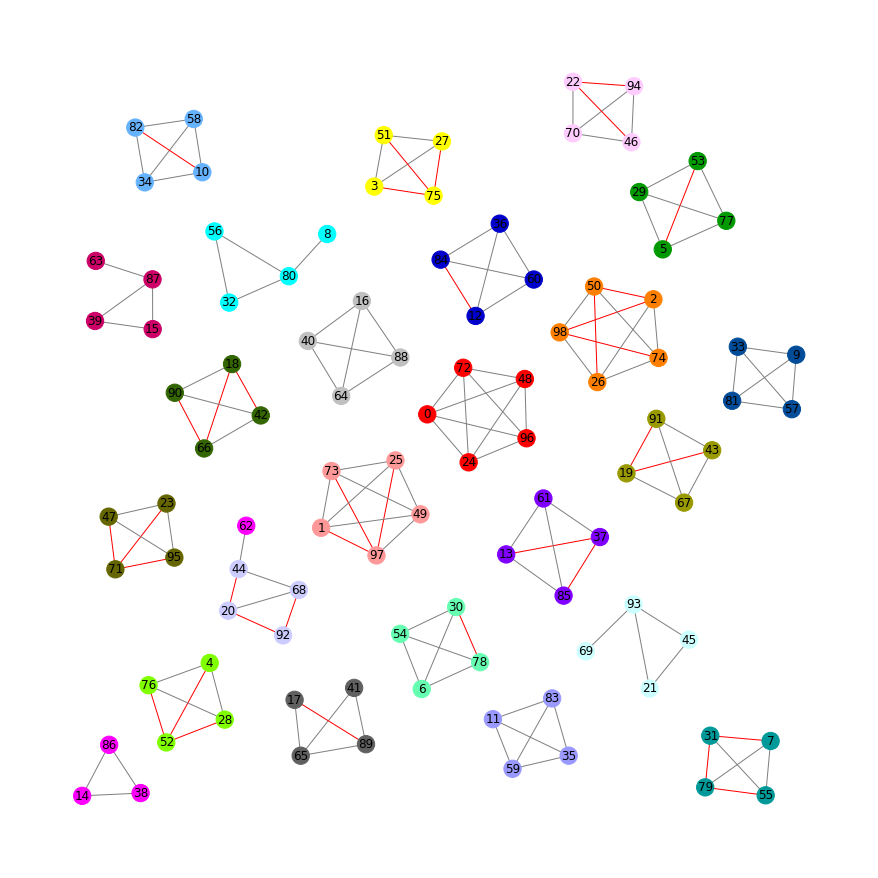

<Figure size 432x288 with 0 Axes>

In [10]:
num_comp = 24
P_community_weights = P.copy()
community_detection_weight()
# draw_P(P_community_weights, file_name='lowest_weights')
draw_P(P_community_weights)

#### GIRVAN NEWMAN <a class="anchor" id="execution_gn"></a> 

In [11]:
# num_comp = 24
# P_girvan_newman = P.copy()
# for u,v in P_girvan_newman.edges():
#     P_girvan_newman[u][v]['weight'] = 10000*(1/(P_girvan_newman[u][v]['weight']*P_girvan_newman[u][v]['weight']))
# girvan_newman()
# draw_P(P_girvan_newman)

#### CLIQUES <a class="anchor" id="execution_cliques"></a>

In [12]:
# cliques = community_detection_clique()

# # draw top 10 cliques
# i = 0
# for c in cliques:
#     if i>=10:
#         break
#     i+=1
#     clique = P.subgraph(c)
#     to_draw_P(clique)

#### LOUVAIN <a class="anchor" id="execution_louvain"></a>

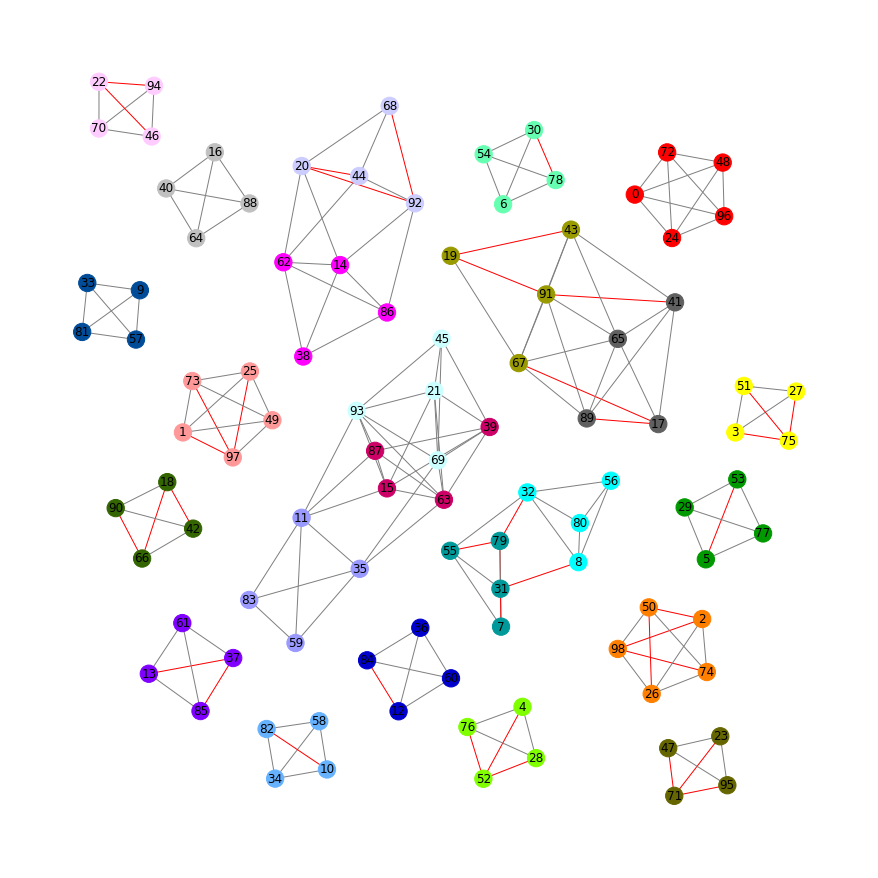

<Figure size 432x288 with 0 Axes>

In [13]:
P_louvain = P.copy()
louvain_communities()
# draw_P(P_louvain, file_name='louvain')
draw_P(P_louvain)

# LOAD GRAPH PROGRESSIONS <a class="anchor" id="load_graph_pregressions"></a>

#### UNVACCINATED MODEL

In [14]:
Ga = []
Pa = []
i = 0
x = 0
while x < TS:
    x = i*100
    i+=1
#     
    fp = open("images/graphP"+str(x)+".json")
    fg = open("images/graphG"+str(x)+".json")

    edges = fp.read().split('\n')
    fp.close()
    p = nx.Graph()
    for edge in edges:
        if edge == '':
            continue
        e = json.loads(edge)
        p.add_edge(e['u'], e['v'], weight=e['weight'], color=e['color'], contacts=e['contacts'])
        p.nodes[e['u']]['dest'] = e['u_public']
        p.nodes[e['v']]['dest'] = e['v_public']

    edges = fg.read().split('\n')
    fg.close()
    g = nx.DiGraph()
    for edge in edges:
        if edge == '':
            continue
        e = json.loads(edge)
        g.add_edge(e['u'], e['v'])
        g.nodes[e['u']]['state'] = e['u_state']
        g.nodes[e['v']]['state'] = e['v_state']
    
    if (g.number_of_nodes() == 0):
        g.add_node(INITIAL_INFECTION,state="State.INFECTIOUS")
    Ga.append(g)
    Pa.append(p)
    
    

In [15]:
MGa = []
MPa = []
i = 0
x = 0
while x < MTS:
    x = i*100
    i+=1
#     
    fp = open("images/mask_graphP"+str(x)+".json")
    fg = open("images/mask_graphG"+str(x)+".json")

    edges = fp.read().split('\n')
    fp.close()
    p = nx.Graph()
    for edge in edges:
        if edge == '':
            continue
        e = json.loads(edge)
        p.add_edge(e['u'], e['v'], weight=e['weight'], color=e['color'], contacts=e['contacts'])
        p.nodes[e['u']]['dest'] = e['u_public']
        p.nodes[e['v']]['dest'] = e['v_public']

    edges = fg.read().split('\n')
    fg.close()
    g = nx.DiGraph()
    for edge in edges:
        if edge == '':
            continue
        e = json.loads(edge)
        g.add_edge(e['u'], e['v'])
        g.nodes[e['u']]['state'] = e['u_state']
        g.nodes[e['v']]['state'] = e['v_state']
    
    if (g.number_of_nodes() == 0):
        g.add_node(INITIAL_INFECTION,state="State.INFECTIOUS")
    MGa.append(g)
    MPa.append(p)

#### VACCINATED MODEL

In [16]:
VGa = []
VPa = []
VCa = []
i = 0
x = 0
while x < VTS:
    x = i*100
    i+=1
#     
    fp = open("images/vax_graphP"+str(x)+".json")
    fg = open("images/vax_graphG"+str(x)+".json")
    fvc = open("images/vax_graphVC"+str(x)+".json")
    edges = fp.read().split('\n')
    fp.close()
    p = nx.Graph()
    for edge in edges:
        if edge == '':
            continue
        e = json.loads(edge)
        p.add_edge(e['u'], e['v'], weight=e['weight'], color=e['color'], contacts=e['contacts'])
        p.nodes[e['u']]['dest'] = e['u_public']
        p.nodes[e['v']]['dest'] = e['v_public']

    edges = fg.read().split('\n')
    fg.close()
    g = nx.DiGraph()
    for edge in edges:
        if edge == '':
            continue
        e = json.loads(edge)
        g.add_edge(e['u'], e['v'])
        g.nodes[e['u']]['state'] = e['u_state']
        g.nodes[e['v']]['state'] = e['v_state']
    
    edges = fvc.read().split('\n')
    fvc.close()
    vc = nx.Graph()
    for edge in edges:
        if edge == '':
            continue
        e = json.loads(edge)
        vc.add_edge(e['u'], e['v'])
        vc.nodes[e['u']]['is_active'] = e['u_vaxxed']
        vc.nodes[e['v']]['is_active'] = e['v_vaxxed']
    if (g.number_of_nodes() == 0):
        g.add_node(INITIAL_INFECTION,state="State.INFECTIOUS")
    VGa.append(g)
    VPa.append(p)
    
    
    
    
    
    
    if not x%600 == 0 or x < 2600:
        continue
    VCa.append(vc)

In [17]:
# draw_VC(households(VCa[len(VCa)-1]))

# LINK PREDICTION <a class="anchor" id="link_prediction"></a>

In [18]:
C = nx.Graph()
t0=int(len(Pa)/2)
t1=len(Pa) - 1
for x in Pa[t0]:
    friends_x = Pa[t0].neighbors(x)
    for z in friends_x:
        friends_z = Pa[t0].neighbors(z)
        for y in friends_z:
            if not(y == x or y in friends_x):
                if not C.has_edge(x, y):
                    C.add_edge(x,y)



new_edges = []

for e in Pa[t1].edges:
    if not (Pa[t0].has_edge(e[0],e[1])):
        new_edges.append(e)
len(new_edges)

238

## PREDICTORS <a class="anchor" id="lp_predictors"></a>

#### RANDOM PREDICTOR <a class="anchor" id="lp_rp"></a>

In [19]:
rp = list(C.edges)
random.shuffle(rp)
# rp

#### COMMON NEIGHBORS <a class="anchor" id="lp_cn"></a>

In [20]:
common_neighbors = []
for e in C.edges:
    cn = len(sorted(nx.common_neighbors(Pa[t0],e[0],e[1])))
    common_neighbors.append((e[0],e[1],cn))
common_neighbors.sort(key=lambda x: x[2], reverse = True)
# common_neighbors

#### JACCARD <a class="anchor" id="lp_jc"></a>

In [21]:
jc = nx.jaccard_coefficient(Pa[t0],list(C.edges))
jaccard_candidate_scores = sorted(jc)
jaccard_candidate_scores.sort(key=lambda x: x[2], reverse = True)
# jaccard_candidate_scores

#### PREFERENTIAL ATTACHMENT <a class="anchor" id="lp_pa"></a>

In [22]:
pa = sorted(nx.preferential_attachment(Pa[t0],list(C.edges)))
pa.sort(key=lambda x: x[2], reverse = True)
# pa

####  ADAMIC/ADAR <a class="anchor" id="lp_aa"></a>

In [23]:
aa = sorted(nx.adamic_adar_index(Pa[t0],list(C.edges)))
aa.sort(key=lambda x: x[2], reverse = True)
# aa

## EXECUTION <a class="anchor" id="link_prediction_execution"></a>

In [24]:
def precision_at_k(k):
    try:
        print('Random Predictor at k=' + str(k) + ':')
        precision = 0.0
        for x in range(k):
            if Pa[t1].has_edge(rp[x][0],rp[x][1]):
                precision += 1.0
        precision /= k
        print(str(round(precision*100,2)) + '%')
        print('Common Neighbors at k=' + str(k) + ':')
        precision = 0.0
        for x in range(k):
            if Pa[t1].has_edge(common_neighbors[x][0],common_neighbors[x][1]):
                precision += 1.0
        precision /= k
        print(str(round(precision*100,2)) + '%')
        print('Jaccard Coefficient at k=' + str(k) + ':')
        precision = 0.0
        for x in range(k):
            if Pa[t1].has_edge(jaccard_candidate_scores[x][0],jaccard_candidate_scores[x][1]):
                precision += 1.0
        precision /= k
        print(str(round(precision*100,2)) + '%')
        print('Preferential Attachment at k=' + str(k) + ':')
        precision = 0.0
        for x in range(k):
            if Pa[t1].has_edge(pa[x][0],pa[x][1]):
                precision += 1.0
        precision /= k
        print(str(round(precision*100,2)) + '%')
        print('Adamic/Adar at k=' + str(k) + ':')
        precision = 0.0
        for x in range(k):
            if Pa[t1].has_edge(aa[x][0],aa[x][1]):
                precision += 1.0
        precision /= k
        print(str(round((precision*100),2)) + '%')
        print('\n')
    except:
        return


In [25]:
# k_vals = [10,20,50,75,100,200,500]
k_vals = [10,20,30,40,50,60,70,80,90,100]
for k in k_vals:    
    precision_at_k(k)

Random Predictor at k=10:
20.0%
Common Neighbors at k=10:
100.0%
Jaccard Coefficient at k=10:
100.0%
Preferential Attachment at k=10:
40.0%
Adamic/Adar at k=10:
100.0%


Random Predictor at k=20:
20.0%
Common Neighbors at k=20:
90.0%
Jaccard Coefficient at k=20:
100.0%
Preferential Attachment at k=20:
55.0%
Adamic/Adar at k=20:
90.0%


Random Predictor at k=30:
26.67%
Common Neighbors at k=30:
80.0%
Jaccard Coefficient at k=30:
93.33%
Preferential Attachment at k=30:
53.33%
Adamic/Adar at k=30:
86.67%


Random Predictor at k=40:
22.5%
Common Neighbors at k=40:
70.0%
Jaccard Coefficient at k=40:
87.5%
Preferential Attachment at k=40:
52.5%
Adamic/Adar at k=40:
85.0%


Random Predictor at k=50:
24.0%
Common Neighbors at k=50:
62.0%
Jaccard Coefficient at k=50:
86.0%
Preferential Attachment at k=50:
48.0%
Adamic/Adar at k=50:
80.0%


Random Predictor at k=60:
23.33%
Common Neighbors at k=60:
58.33%
Jaccard Coefficient at k=60:
85.0%
Preferential Attachment at k=60:
45.0%
Adamic/Adar at k=

# STATISTICS <a class="anchor" id="statistics"></a>

## FUNCTIONS <a class="anchor" id="statistics_functions"></a>

In [26]:
def get_R0(graph, g):
    infections = 0
    infectious_nodes = 0
    for n in graph:
        if graph.nodes[n]['state'] == 'State.INFECTIOUS':
            infectious_nodes += 1
            infections+=g.out_degree(n)
    try:
        r0 = round((infections/infectious_nodes),3)
        return r0
    except:
        return 0

def r0_graph_compare(ga, graph, vga, vgraph, save_file = False):
    r0 = []
    i=0
    for g in ga:
        r0.append((100*i,get_R0(g, graph)))
        i+=1
    ts = [x for x, y in r0]
    data = [y for x, y in r0]
    (ax1, ax2) = plt.subplots(ncols=1, figsize=(10, 10))
    plt.plot(ts,data,'-b',label = 'unvaccinated model')
    
    r0 = []
    i=0
    for g in vga:
        r0.append((100*i,get_R0(g, vgraph)))
        i+=1
    ts = [x for x, y in r0]
    data = [y for x, y in r0]
    plt.plot(ts,data,'-g',label = 'vaccinated model')
    
    plt.title("R0 values")
    ax2.set_xlabel('Time Stamp')
    ax2.set_ylabel('R0')
    plt.legend(loc="best")
    if save_file:
        plt.savefig("images/r0_compare.png")
    plt.show()
    plt.clf()


def r0_graph_compare_mask(ga, graph, vga, vgraph, save_file = False):
    r0 = []
    i=0
    for g in ga:
        r0.append((100*i,get_R0(g, graph)))
        i+=1
    ts = [x for x, y in r0]
    data = [y for x, y in r0]
    (ax1, ax2) = plt.subplots(ncols=1, figsize=(10, 10))
    plt.plot(ts,data,'-b',label = 'unmasked model')
    
    r0 = []
    i=0
    for g in vga:
        r0.append((100*i,get_R0(g, vgraph)))
        i+=1
    ts = [x for x, y in r0]
    data = [y for x, y in r0]
    plt.plot(ts,data,'-g',label = 'masked model')
    
    plt.title("R0 values")
    ax2.set_xlabel('Time Stamp')
    ax2.set_ylabel('R0')
    plt.legend(loc="best")
    if save_file:
        plt.savefig("images/r0_compare_mask.png")
    plt.show()
    plt.clf()
    
def r0_graph(ga, graph, save_file = False,v = False):
    r0 = []
    i=0
    for g in ga:
        r0.append((100*i,get_R0(g, graph)))
        i+=1
    ts = [x for x, y in r0]
    data = [y for x, y in r0]
    (ax1, ax2) = plt.subplots(ncols=1, figsize=(10, 10))
    plt.plot(ts,data)
    plt.title("R0 values")
    ax2.set_xlabel('Time Stamp')
    ax2.set_ylabel('R0')
    if save_file:
        if v:
            plt.savefig("images/v_r0.png")
        else:
            plt.savefig("images/r0.png")
    plt.show()
    plt.clf()

def infections_graph_compare(ga, vga, save_file = False):
    infections_ts = []
    v_infections_ts = []
    i=0
    for g in ga:
        infections_ts.append((100*i,g.number_of_nodes()))
        i+=1
    i=0
    for g in vga:
        v_infections_ts.append((100*i,g.number_of_nodes()))
        i+=1
    ts = [x for x, y in infections_ts]
    data = [y for x, y in infections_ts]
    (ax1, ax2) = plt.subplots(ncols=1, figsize=(10, 10))
    plt.plot(ts,data,'-b',label = 'unvaccinated model')
    ts = [x for x, y in v_infections_ts]
    data = [y for x, y in v_infections_ts]
    plt.plot(ts,data,'-g',label = 'vaccinated model')
    plt.title("Infections Over Time")
    ax2.set_xlabel('Time Stamp')
    ax2.set_ylabel('Infections')
    plt.legend(loc="best")
    if save_file:
        plt.savefig("images/infections_compare.png")
    plt.show()
    plt.clf()
    
def infections_graph_compare_mask(ga, vga, save_file = False):
    infections_ts = []
    v_infections_ts = []
    i=0
    for g in ga:
        infections_ts.append((100*i,g.number_of_nodes()))
        i+=1
    i=0
    for g in vga:
        v_infections_ts.append((100*i,g.number_of_nodes()))
        i+=1
    ts = [x for x, y in infections_ts]
    data = [y for x, y in infections_ts]
    (ax1, ax2) = plt.subplots(ncols=1, figsize=(10, 10))
    plt.plot(ts,data,'-b',label = 'unmasked model')
    ts = [x for x, y in v_infections_ts]
    data = [y for x, y in v_infections_ts]
    plt.plot(ts,data,'-g',label = 'masked model')
    plt.title("Infections Over Time")
    ax2.set_xlabel('Time Stamp')
    ax2.set_ylabel('Infections')
    plt.legend(loc="best")
    if save_file:
        plt.savefig("images/infections_compare_mask.png")
    plt.show()
    plt.clf()
    
def infections_graph(ga, save_file = False,v = False):
    infections_ts = []
    i=0
    for g in ga:
        infections_ts.append((100*i,g.number_of_nodes()))
        i+=1
    ts = [x for x, y in infections_ts]
    data = [y for x, y in infections_ts]
    (ax1, ax2) = plt.subplots(ncols=1, figsize=(10, 10))
    plt.plot(ts,data)
    plt.title("Infections Over Time")
    ax2.set_xlabel('Time Stamp')
    ax2.set_ylabel('Infections')
    if save_file:
        if v:
            plt.savefig("images/v_infections.png")
        else:
            plt.savefig("images/infections.png")
    plt.show()
    plt.clf()

def get_susceptible(graph):
    return (99 - graph.number_of_nodes())

def get_infectious(graph):
    infectious_nodes = 0
    for n in graph:
        if graph.nodes[n]['state'] == 'State.INFECTIOUS':
            infectious_nodes += 1
    return infectious_nodes

def get_recovered(graph):
    recovered_nodes = 0
    for n in graph:
        if graph.nodes[n]['state'] == 'State.RECOVERED':
            recovered_nodes += 1
    return recovered_nodes

def susceptible_graph(ga, save_file = False,v = False):
    susceptible_ts = []
    i=0
    for g in ga:
        susceptible_ts.append((100*i,get_susceptible(g)))
        i+=1
    ts = [x for x, y in susceptible_ts]
    data = [y for x, y in susceptible_ts]
    (ax1, ax2) = plt.subplots(ncols=1, figsize=(10, 10))
    plt.plot(ts,data)
    plt.title("Susceptible Nodes Over Time")
    ax2.set_xlabel('Time Stamp')
    ax2.set_ylabel('Susceptible')
    if save_file:
        if v:
            plt.savefig("images/v_susceptible.png")
        else:
            plt.savefig("images/susceptible.png")
    plt.show()
    plt.clf()

def infectious_graph(ga, save_file = False,v = False):
    infections_ts = []
    i=0
    for g in ga:
        infections_ts.append((100*i,get_infectious(g)))
        i+=1
    ts = [x for x, y in infections_ts]
    data = [y for x, y in infections_ts]
    (ax1, ax2) = plt.subplots(ncols=1, figsize=(10, 10))
    plt.plot(ts,data)
    plt.title("Infectious Nodes Over Time")
    ax2.set_xlabel('Time Stamp')
    ax2.set_ylabel('Infectious')
    if save_file:
        if v:
            plt.savefig("images/v_infectious.png")
        else:
            plt.savefig("images/infectious.png")
    plt.show()
    plt.clf()

def recovered_graph(ga, save_file = False,v = False):
    recovered_ts = []
    i=0
    for g in ga:
        recovered_ts.append((100*i,get_recovered(g)))
        i+=1
    ts = [x for x, y in recovered_ts]
    data = [y for x, y in recovered_ts]
    (ax1, ax2) = plt.subplots(ncols=1, figsize=(10, 10))
    plt.plot(ts,data)
    plt.title("Recovered Nodes Over Time")
    ax2.set_xlabel('Time Stamp')
    ax2.set_ylabel('Recovered')
    if save_file:
        if v:
            plt.savefig("images/v_recovered.png")
        else:
            plt.savefig("images/recovered.png")
    plt.show()
    plt.clf()
    
def sir_graph(ga, save_file = False, v = False, m = False):
    susceptible_ts = []
    i=0
    for g in ga:
        susceptible_ts.append((100*i,get_susceptible(g)))
        i+=1
    s_ts = [x for x, y in susceptible_ts]
    s_data = [y for x, y in susceptible_ts]
    infections_ts = []
    i=0
    for g in ga:
        infections_ts.append((100*i,get_infectious(g)))
        i+=1
    i_ts = [x for x, y in infections_ts]
    i_data = [y for x, y in infections_ts]
    recovered_ts = []
    i=0
    for g in ga:
        recovered_ts.append((100*i,get_recovered(g)))
        i+=1
    r_ts = [x for x, y in recovered_ts]
    r_data = [y for x, y in recovered_ts]
    (ax1, ax2) = plt.subplots(ncols=1, figsize=(10, 10))
    plt.plot(s_ts,s_data,'-b',label = 'susceptible')
    plt.plot(i_ts,i_data,'-r',label = 'infectious')
    plt.plot(r_ts,r_data,'black',label = 'recovered')
    plt.legend(loc="best")
    plt.title("SIR Over Time")
    ax2.set_xlabel('Time Stamp')
    ax2.set_ylabel('Nodes')
    if save_file:
        if v:
            plt.savefig("images/v_sir_model.png")
        elif m:
            plt.savefig("images/m_sir_model.png")
        else:
            plt.savefig("images/sir_model.png")
    plt.show()
    plt.clf()

def get_vaxxed(graph):
    active_nodes = 0
    for n in graph:
        if graph.nodes[n]['is_active']:
            active_nodes += 1
    return active_nodes
    
def vaccination_graph(vca, save_file = False):
    vaxxed_ts = []
    i=0
    for g in vca:
        vaxxed_ts.append(((600*i+3200),get_vaxxed(g)))
        i+=1
    ts = [x for x, y in vaxxed_ts]
    data = [y for x, y in vaxxed_ts]
    (ax1, ax2) = plt.subplots(ncols=1, figsize=(10, 10))
    plt.plot(ts,data)
    plt.title("Vaccinated Nodes Over Time")
    ax2.set_xlabel('Time Stamp')
    ax2.set_ylabel('Vaccinated')
    if save_file:
        plt.savefig("images/vaccinations.png")
    plt.show()
    plt.clf() 

## EXECUTION <a class="anchor" id="statistics_execution"></a>

#### SIR GRAPH <a class="anchor" id="sir"></a>

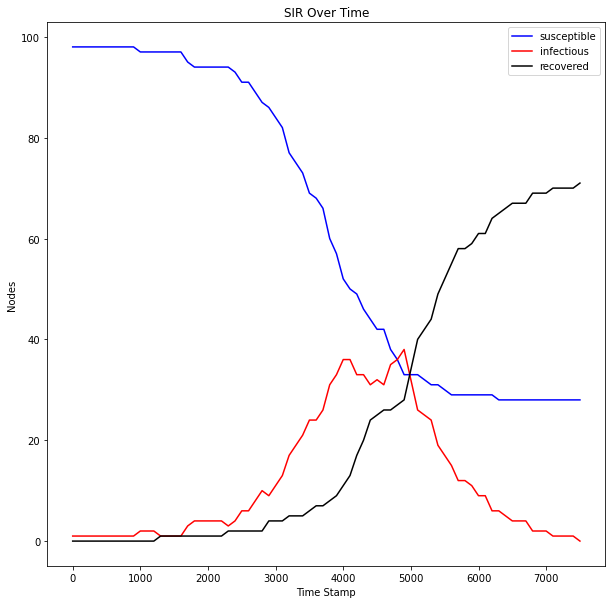

<Figure size 432x288 with 0 Axes>

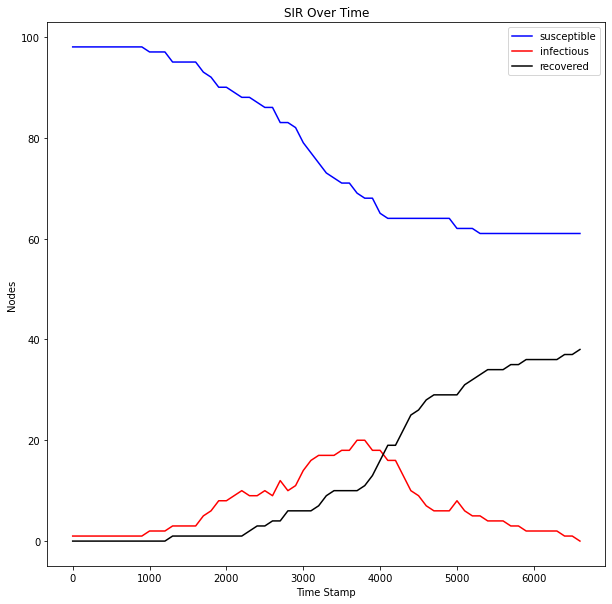

<Figure size 432x288 with 0 Axes>

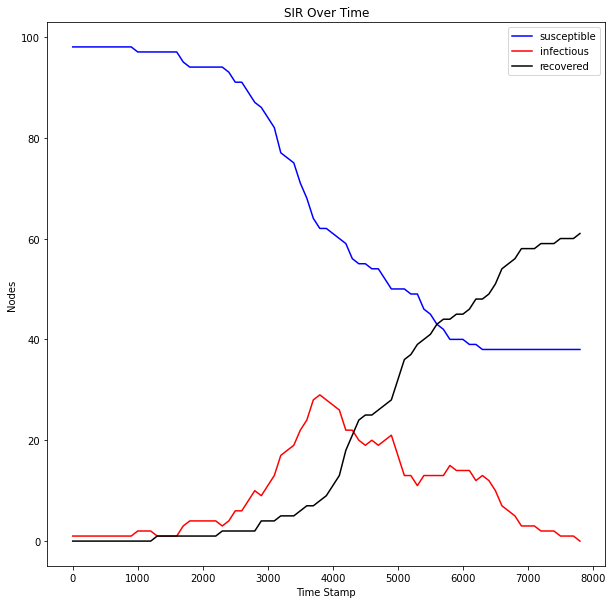

<Figure size 432x288 with 0 Axes>

In [27]:
sir_graph(Ga)
sir_graph(VGa)
sir_graph(MGa)

#### R0 GRAPH <a class="anchor" id="r0"></a>

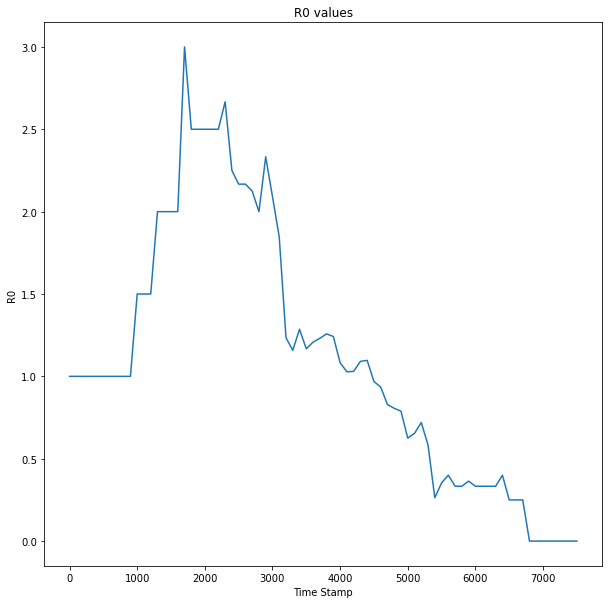

<Figure size 432x288 with 0 Axes>

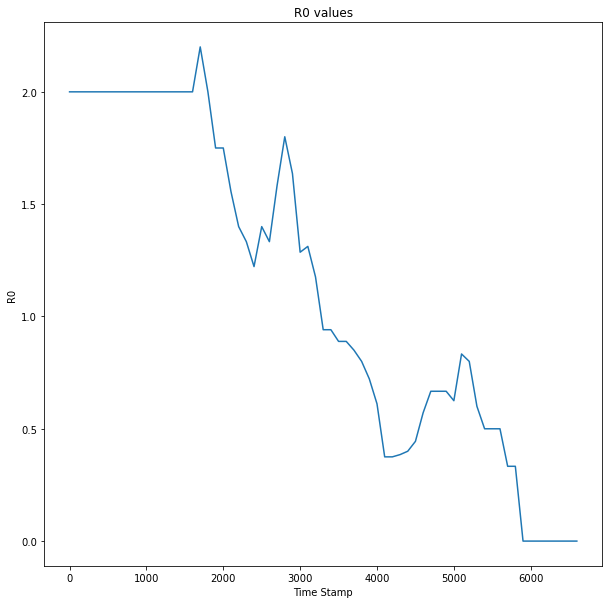

<Figure size 432x288 with 0 Axes>

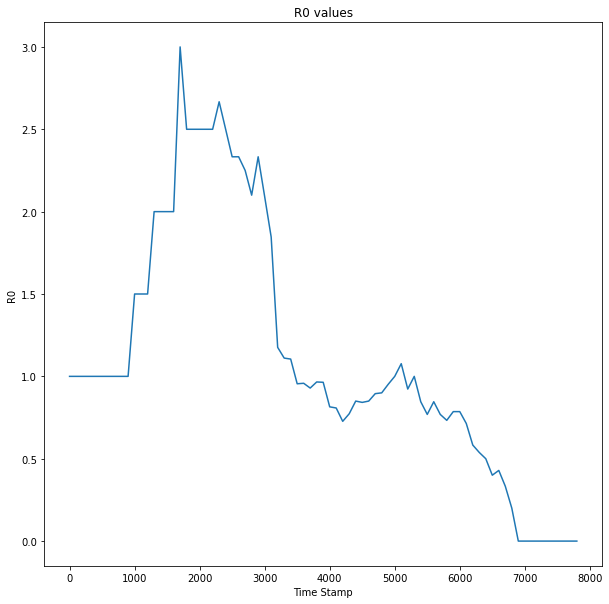

<Figure size 432x288 with 0 Axes>

In [28]:
r0_graph(Ga, G) 
r0_graph(VGa, VG) 
r0_graph(MGa, MG)

#### INFECTIONS GRAPH <a class="anchor" id="infections"></a>

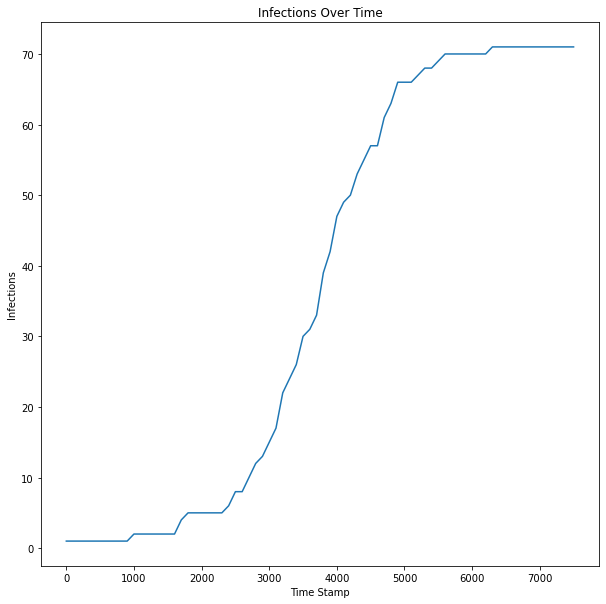

<Figure size 432x288 with 0 Axes>

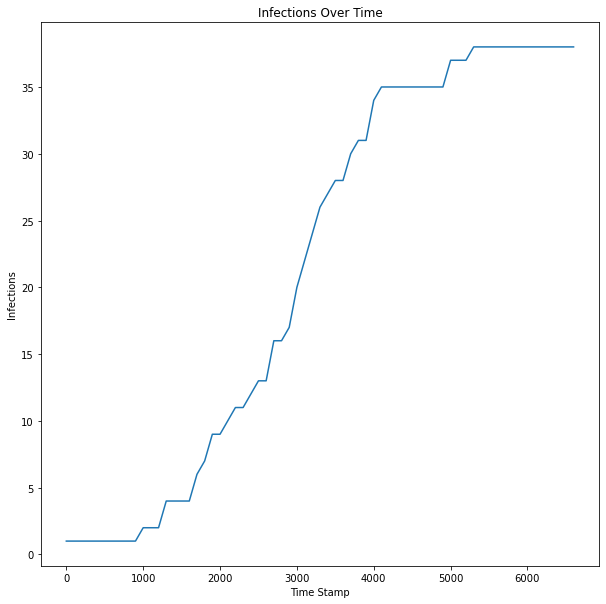

<Figure size 432x288 with 0 Axes>

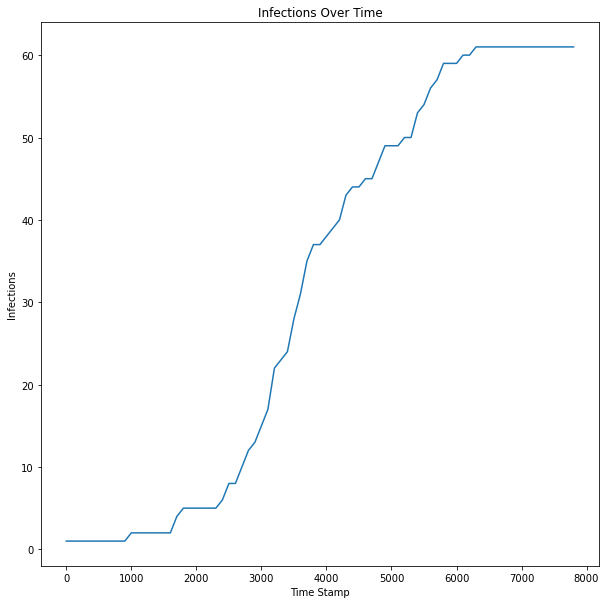

<Figure size 432x288 with 0 Axes>

In [29]:
infections_graph(Ga)
infections_graph(VGa)
infections_graph(MGa)


## Final Infections Results <a class="anchor" id="fir"></a>

In [30]:
# No Preventative Measures
low = 0
med = 0
high = 0
for n in G:
    if n < 33:
        med+=1
    elif n < 66:
        low+=1
    else:
        high+=1
print('Low Vulnerability Infections: '+str(low))
print('Medium Vulnerability Infections: '+str(med))
print('High Vulnerability Infections: '+str(high))
print(str(low+med+high)+'/99 Nodes infected.')

Low Vulnerability Infections: 15
Medium Vulnerability Infections: 28
High Vulnerability Infections: 28
71/99 Nodes infected.


In [31]:
# Masked Model
low = 0
med = 0
high = 0
for n in MG:
    if n < 33:
        med+=1
    elif n < 66:
        low+=1
    else:
        high+=1
print('Low Vulnerability Infections: '+str(low))
print('Medium Vulnerability Infections: '+str(med))
print('High Vulnerability Infections: '+str(high))
print(str(low+med+high)+'/99 Nodes infected.')

Low Vulnerability Infections: 16
Medium Vulnerability Infections: 23
High Vulnerability Infections: 22
61/99 Nodes infected.


In [32]:
# Vaccinated Model
low = 0
med = 0
high = 0
for n in VG:
    if n < 33:
        med+=1
    elif n < 66:
        low+=1
    else:
        high+=1
print('Low Vulnerability Infections: '+str(low))
print('Medium Vulnerability Infections: '+str(med))
print('High Vulnerability Infections: '+str(high))
print(str(low+med+high)+'/99 Nodes infected.')

Low Vulnerability Infections: 9
Medium Vulnerability Infections: 14
High Vulnerability Infections: 15
38/99 Nodes infected.


## Vaccination Cascade | Linear Threshold Model <a class="anchor" id="vc"></a>

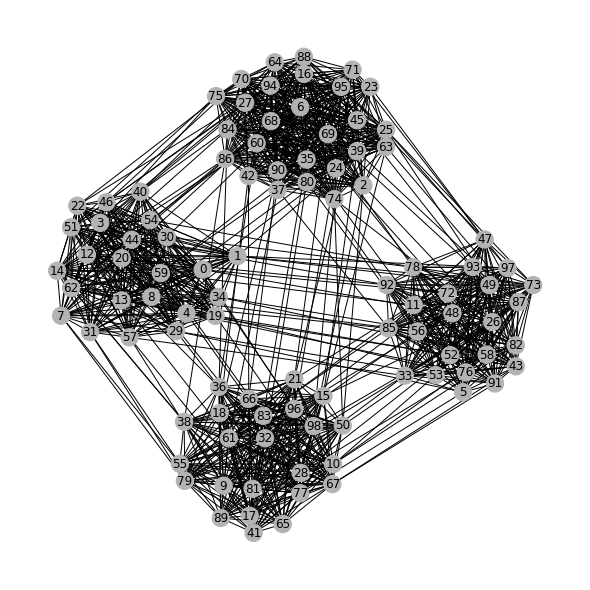

<Figure size 432x288 with 0 Axes>

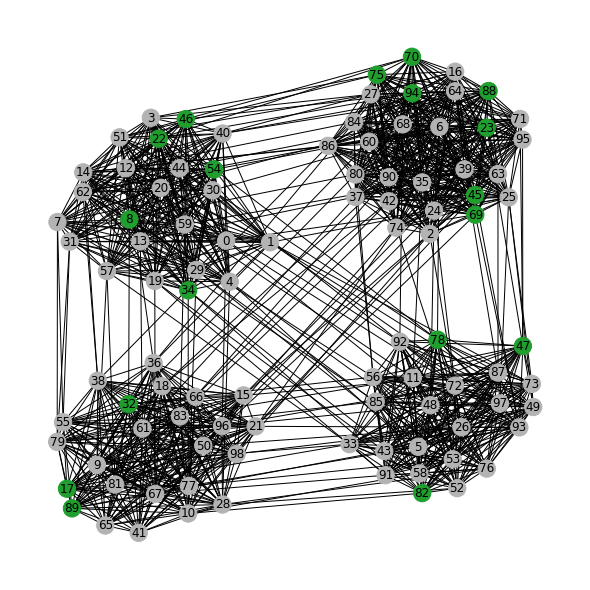

<Figure size 432x288 with 0 Axes>

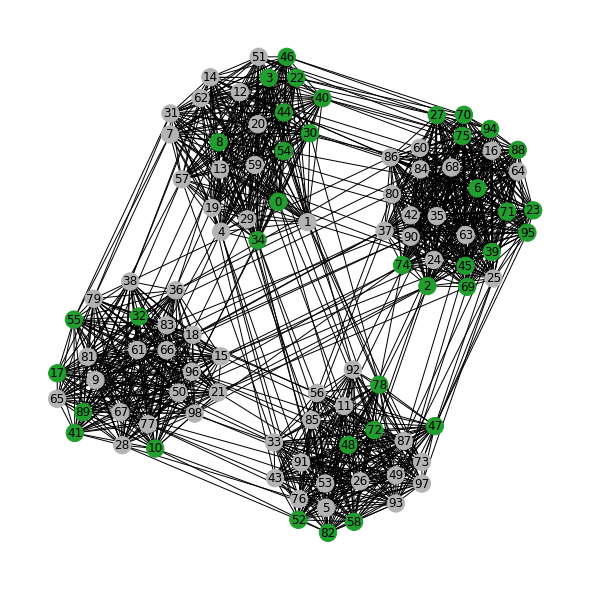

<Figure size 432x288 with 0 Axes>

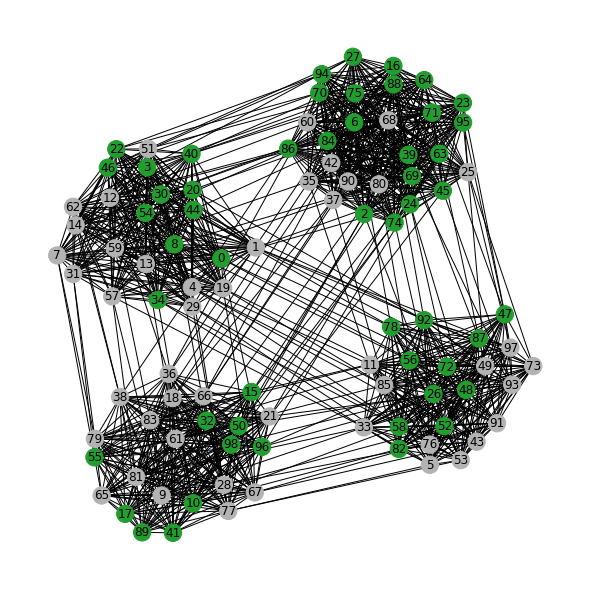

<Figure size 432x288 with 0 Axes>

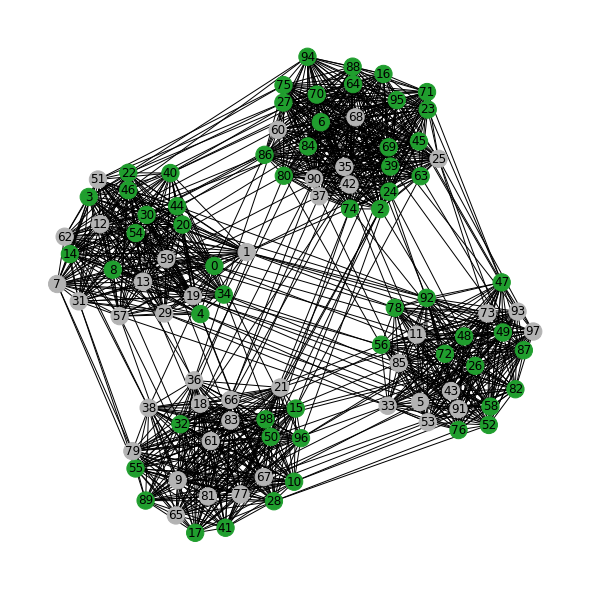

<Figure size 432x288 with 0 Axes>

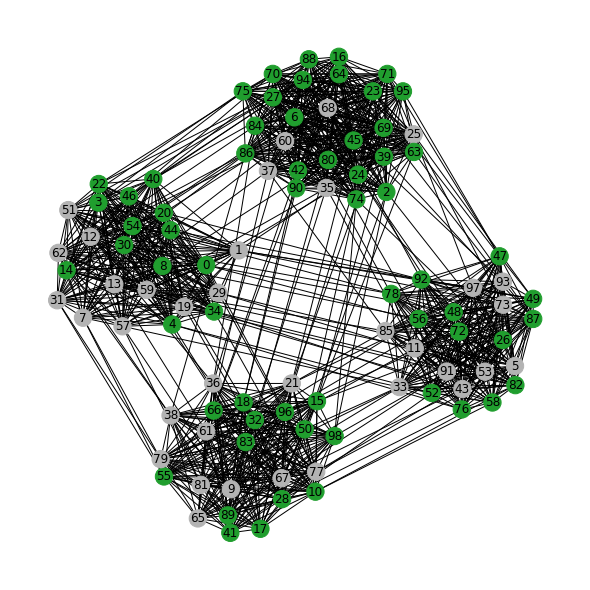

<Figure size 432x288 with 0 Axes>

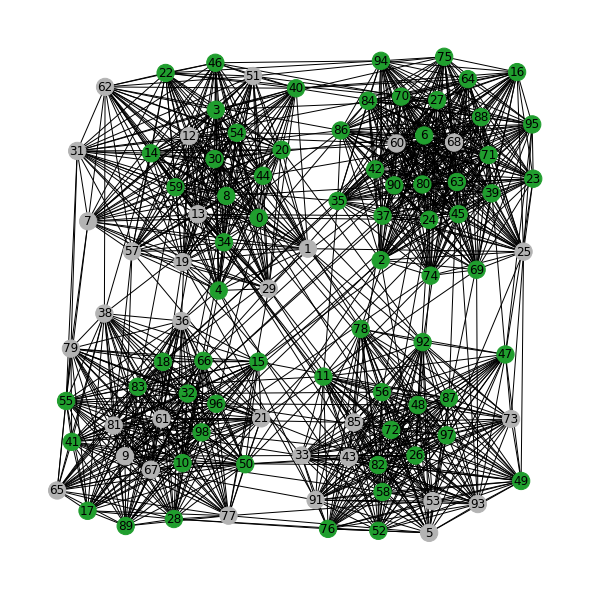

<Figure size 432x288 with 0 Axes>

In [33]:
for i in range(len(VCa)):
    if i != 0 and get_vaxxed(VCa[i]) != get_vaxxed(VCa[i-1]):
        draw_VC(VCa[i], file_name=('vax_cascade' + str(i)))
    elif i == 0:
        draw_VC(VCa[i], file_name=('vax_cascade' + str(i)))
    else:
        break